# 3. Gyakorlat: Regularizált modellek
## Lasso, Ridge, Elastic net

In [17]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modellezési eljárások
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import MultiTaskElasticNetCV

# Adatátalakítási könyvtárak
from sklearn.base import clone
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

## Random adatok

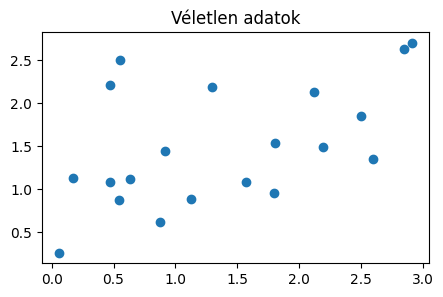

In [18]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

plt.figure(figsize=(5, 3))
plt.title("Véletlen adatok")
plt.scatter(X, y)
plt.show()

## Ridge

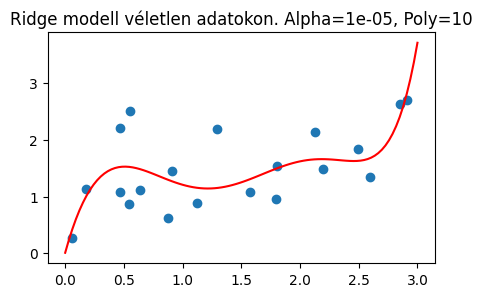

In [19]:
# Próbáljuk meg állítgatni a hiperparamétereket! Milyen változást figyelhetünk meg? 
poly_deg = 10
ridge_alpha = 0.00001

reg = Ridge(alpha=ridge_alpha, solver="cholesky", random_state=42) 

# Transzformációs csővezeték
model = Pipeline([
    ("poly_features", PolynomialFeatures(degree=poly_deg, include_bias=False)),  # Polinomikus jellemzők hozzáadása
    ("std_scaler", StandardScaler()),  # Sztenderdizálás és normalizálás
    ("regul_reg", reg)
])  # Regresszor ráküldése

model.fit(X, y)
y_new_regul = model.predict(X_new)

plt.figure(figsize=(5, 3))
plt.title("Ridge modell véletlen adatokon. Alpha="+str(ridge_alpha)+", Poly="+str(poly_deg))
plt.title(f"Ridge modell véletlen adatokon. Alpha={ridge_alpha}, Poly={poly_deg}")
plt.plot(X_new, y_new_regul, 'r')
plt.scatter(X, y)
plt.show()

## LASSO

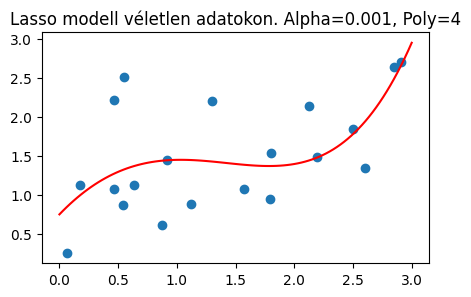

In [20]:
# Hiperparaméterek felvétele. Milyen változásokat tapasztalunk?
lasso_alpha = 0.001
poly_deg = 4

reg = Lasso(alpha=lasso_alpha) # Próbáljuk meg állítgatni az alpha hiperparamétert!

model = Pipeline([ # Mi hiányzik a modell csővezetékből?
    ("poly_features", PolynomialFeatures(degree=poly_deg, include_bias=False)), 
    ("regul_reg", reg)])

model.fit(X, y)

y_new_regul = model.predict(X_new)

plt.figure(figsize=(5, 3))
plt.title("Lasso modell véletlen adatokon. Alpha="+str(lasso_alpha)+", Poly="+str(poly_deg))
plt.plot(X_new, y_new_regul, 'r')
plt.scatter(X, y)
plt.show()

## Early stopping
Adatok generálása

In [21]:
# Adatok generálása
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)  # Tanító-teszt szétválasztás

### Egy egyszerű Early Stopping implementáció

In [22]:
poly_scaler = Pipeline([ # Jellemzők szerkesztése
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),  # Polinomikus jellemzők felvétele
        ("std_scaler", StandardScaler())  # Jellemzők méretezése
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

# Egy regresszor definiálása az early stopping demonstrálására
sgd_reg = SGDRegressor(
    max_iter = 1,  # A modell: ez lehet bármi aminek kiszámolható a hibája
    tol = 1e-3,  # Megállítási kritérium
    warm_start = True,  # Megtartja az előző modellt, és azt tanítja tovább
    penalty = None,  # Büntetés: Próbáljuk meg regularizálni!
    learning_rate = "constant",  # Van-e adaptív tanulási sebesség
    eta0 = 0.0005,  # Kezdeti tanulási sebesség
    random_state = 42,  # Véletlenszám-generáló bázisértéke
) 

# Tanítás és early stopping futtatása
minimum_val_error = float("inf")
best_epoch = None
best_model = None
error_track = []
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # Folytassa ott, ahol abbahagyta
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    error_track.append(val_error)
    
    if val_error < minimum_val_error: # Early Stopping kritérium
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

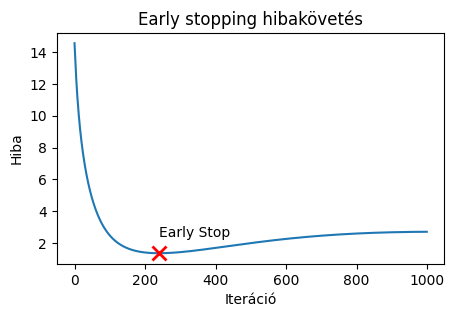

In [23]:
plt.figure(figsize=(5, 3))
plt.title("Early stopping hibakövetés")
plt.plot(error_track)
plt.plot(best_epoch, error_track[best_epoch], color='red', marker='x', markersize=10, markeredgewidth='2')
plt.annotate('Early Stop', xy = (best_epoch, error_track[best_epoch] + 1))
plt.xlabel("Iteráció")
plt.ylabel("Hiba")
plt.show()

## Elasztikus háló a halas adatokon
Adatok előkészítése

In [24]:
df = pd.read_csv('halak.csv', header=0, sep=';', encoding='ISO-8859-2')

df = df[['Suly', 'Hossz1', 'Hossz2', 'Hossz3', 'Magassag', 'Szelesseg']]

# df_X = df[['Hossz1']]

df_X = df[['Magassag']] # Próbáljuk ki ezzel is! 

poly_scaler = Pipeline([("std_scaler", StandardScaler())])

X = poly_scaler.fit_transform(df_X)
Y = df['Hossz1']

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.5, random_state=420)

#### Korrelációs mátrix

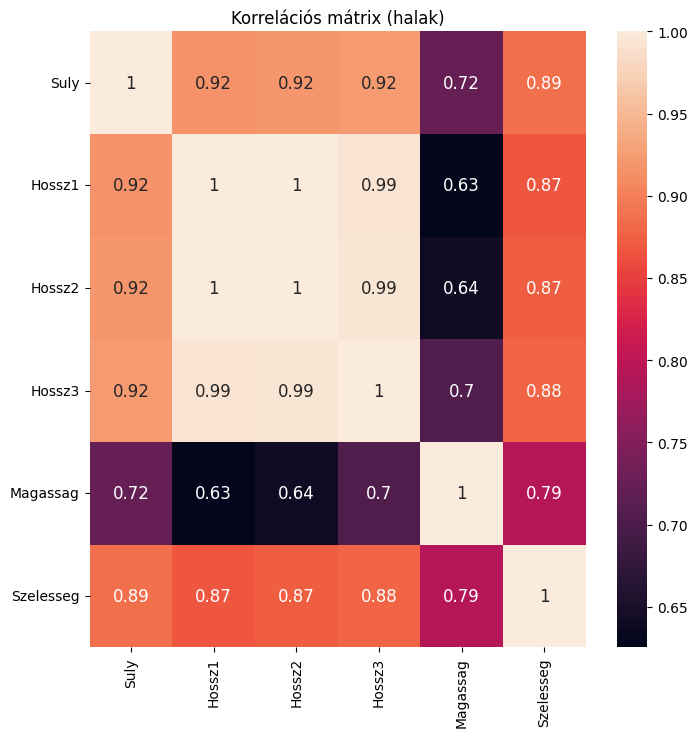

In [25]:
corr = df.corr() 

plt.figure(figsize=(5, 5))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values,  annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(8,8)
plt.title('Korrelációs mátrix (halak)')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### Adatok vizsgálata

In [26]:
display(df.head())

print('x_train')
display(pd.DataFrame(X_train).head())
print()

print('y_train')
display(pd.DataFrame(y_train).head())
print()

print('x_train méret')
print(len(X_train))

print('x_test méret')
print(len(X_val))

,Suly,Hossz1,Hossz2,Hossz3,Magassag,Szelesseg
0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,290.0,24.0,26.3,31.2,12.4800,4.3056
2,340.0,23.9,26.5,31.1,12.3778,4.6961
3,363.0,26.3,29.0,33.5,12.7300,4.4555
4,430.0,26.5,29.0,34.0,12.4440,5.1340


x_train


,0
0,0.812835
1,-0.785074
2,0.147215
3,2.121818
4,-0.336226



y_train


,Hossz1
4,26.5
38,18.2
143,56.0
30,35.0
48,22.0



x_train méret
79
x_test méret
80


### Elasztikus háló 

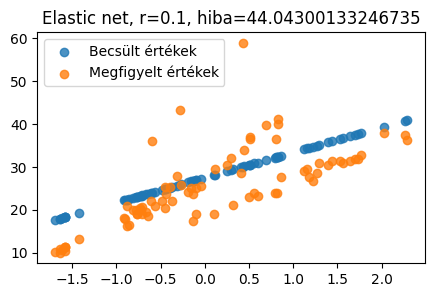

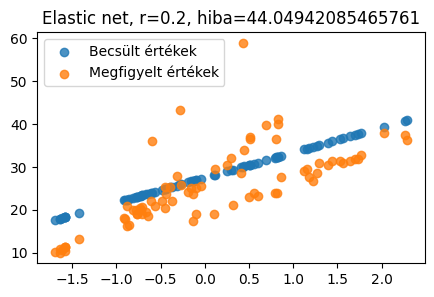

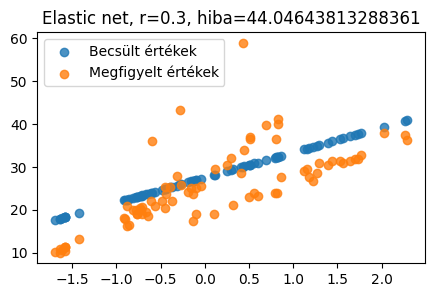

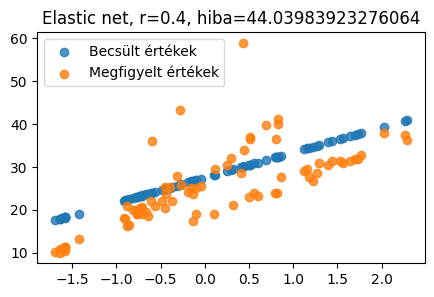

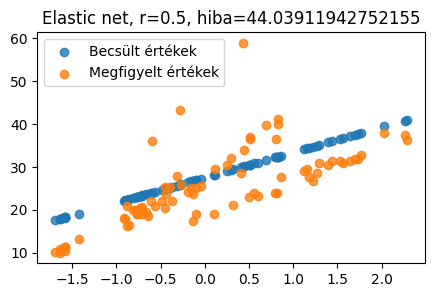

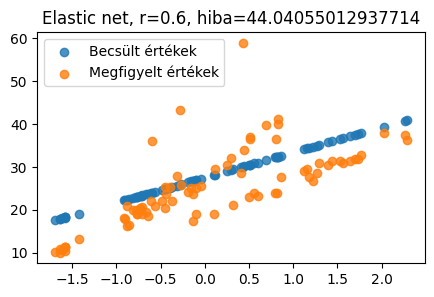

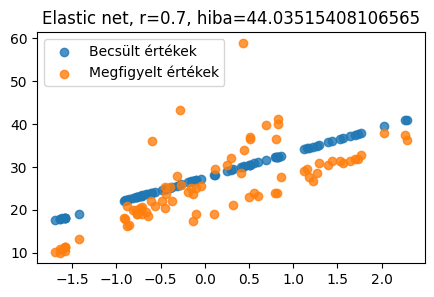

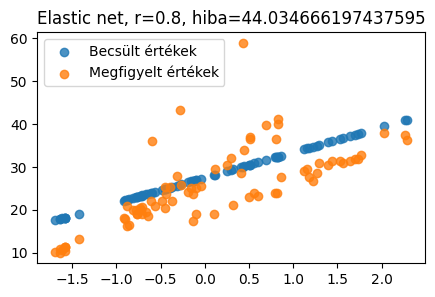

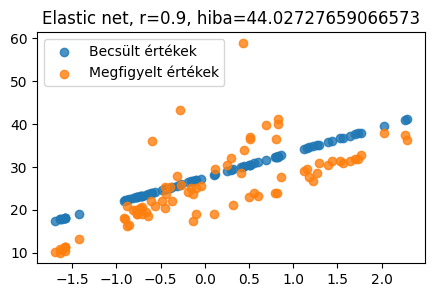

In [27]:
errorlog = {}
for i in range(1, 10, 1):
    r = i/10
    model = ElasticNetCV(l1_ratio=r, fit_intercept=True)
    
    model.fit(X_train, y_train)
    
    y_pred =  model.predict(np.array(X_val).reshape(-1,1))
    
    errorlog[r] = mean_squared_error(y_val, y_pred)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    
    ax.set_title("Elastic net, r="+str(r)+", hiba="+str(errorlog[r]))
    
    ax.scatter(X_val[:,0], y_pred, alpha=0.8, label='Becsült értékek')
    ax.scatter(X_val[:,0], y_val, alpha=0.8, label='Megfigyelt értékek')
    
    ax.legend()
    plt.show()

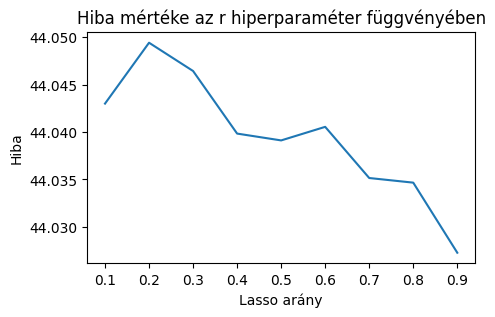

In [28]:
plt.figure(figsize=(5, 3))
plt.title("Hiba mértéke az r hiperparaméter függvényében")
plt.xlabel("Lasso arány")
plt.ylabel("Hiba")
plt.plot(errorlog.keys(), errorlog.values())
plt.show()

## Multitask Elastic Net
Az elasztikus hálózat többváltozós verziója

In [29]:
df_X = df[['Hossz2', 'Hossz3', 'Magassag', 'Szelesseg']]

poly_scaler = Pipeline([("std_scaler", StandardScaler())]) # X átalakítója 

X = poly_scaler.fit_transform(df_X) # X sztenderdizálása

Y = np.array(df['Hossz1']).reshape(-1,1) # Y definiálás

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.5, random_state=420) # train-test kettécsapás

display(df_X)

print('x_train')
display(pd.DataFrame(X_train).head())
print()

print('y_train')
display(pd.DataFrame(y_train).head())
print()

print('x_train méret')
print(len(X_train))

print('x_test méret')
print(len(X_val))

,Hossz2,Hossz3,Magassag,Szelesseg
0,25.4,30.0,11.5200,4.0200
1,26.3,31.2,12.4800,4.3056
2,26.5,31.1,12.3778,4.6961
3,29.0,33.5,12.7300,4.4555
4,29.0,34.0,12.4440,5.1340
...,...,...,...,...
154,12.2,13.4,2.0904,1.3936
155,12.4,13.5,2.4300,1.2690
156,13.0,13.8,2.2770,1.2558
157,14.3,15.2,2.8728,2.0672


x_train


,0,1,2,3
0,0.054694,0.239592,0.812835,0.426371
1,-0.806521,-0.779963,-0.785074,-0.739595
2,2.956616,2.831680,0.147215,1.027385
3,0.943993,1.112261,2.121818,1.123964
4,-0.413358,-0.347949,-0.336226,-0.346497



y_train


,0
0,26.5
1,18.2
2,56.0
3,35.0
4,22.0



x_train méret
79
x_test méret
80


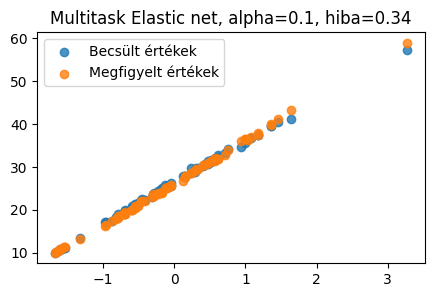

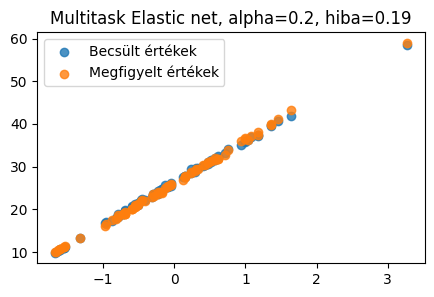

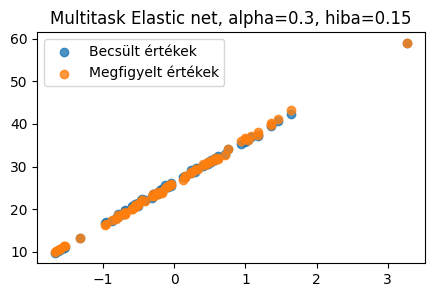

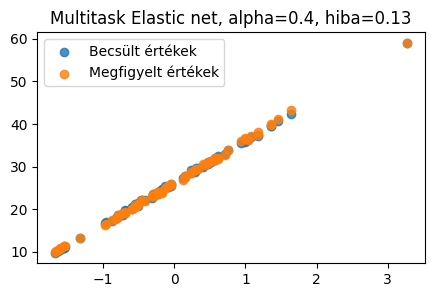

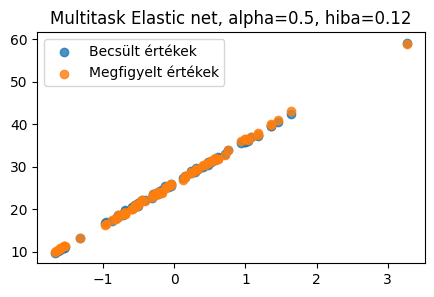

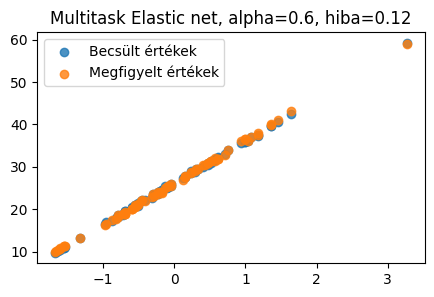

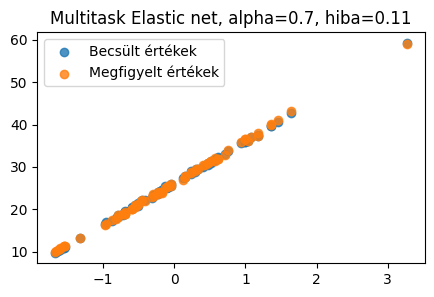

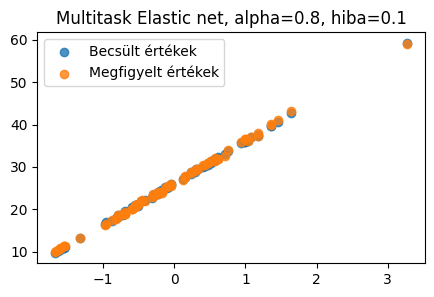

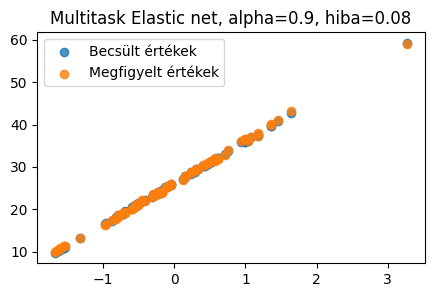

In [30]:
# MultitaskElasticNet futtatása, hiba követése
errorlog_multi = {}
for i in range(1, 10, 1):
    r = i/10
    model = MultiTaskElasticNetCV(l1_ratio=r, fit_intercept=True)
    
    model.fit(X_train, y_train)
    
    y_pred =  model.predict(X_val)
    
    errorlog_multi[r] = mean_squared_error(y_val, y_pred)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.set_title(f"Multitask Elastic net, alpha={r}, hiba={round(errorlog_multi[r], 2)}")
    ax.scatter(X_val[:,0], y_pred, alpha=0.8, label='Becsült értékek')
    ax.scatter(X_val[:,0], y_val, alpha=0.8, label='Megfigyelt értékek')
    
    ax.legend()
    plt.show()

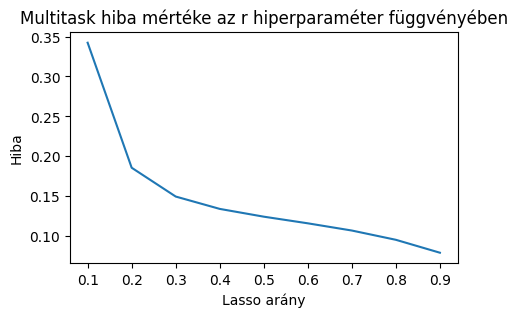

In [31]:
plt.figure(figsize=(5, 3))
plt.title("Multitask hiba mértéke az r hiperparaméter függvényében")
plt.xlabel("Lasso arány")
plt.ylabel("Hiba")
plt.plot(errorlog_multi.keys(), errorlog_multi.values())
plt.show()

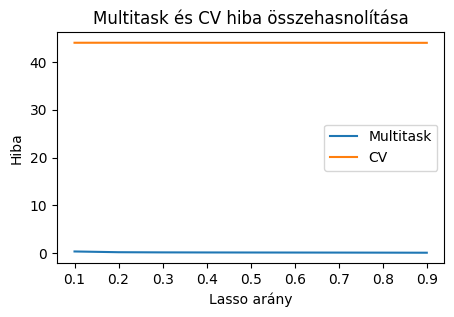

In [32]:
plt.figure(figsize=(5, 3))
plt.title("Multitask és CV hiba összehasnolítása")
plt.xlabel("Lasso arány")
plt.ylabel("Hiba")
plt.plot(errorlog_multi.keys(), errorlog_multi.values(), label="Multitask")
plt.plot(errorlog.keys(), errorlog.values(), label="CV")
plt.legend()
plt.show()